# Vertex Classification

The most common type of analysis that we want to do with a colloidal ice system is to map it to a system of vertices, for which we can then classify and count types of vertices.

A system of vertices is a directed network. A vertex geometry is a set of points $\mathbf{v}_i \in \mathbb{V}$ which define the vertex locations in 3D space. The topology of the vertices is defined by their connectivity; two vertices, $v_i$ and $v_j$ are connected if they are joined by an edge $\mathbf{e}_{ij} = \left(v_i, v_j\right)$, and the set of all edges is $\mathbb{E}$. 
The vertex network is directed, which means that the edge $\mathbf{e}_{ij} \neq \mathbf{e}_{ji}$.

The mapping from a colloidal ice consists on assigning an edge to each trap. An edge's direction goes from the vertex with a hole to the vertex with a particle. 

A vertex object 'v' should be able to guess the vertex geometry and topology that maps a colloidal ice object 'col' for simple systems by writing:

    v.colloids_to_vertices(col)
    
However, some assistance on this guessing could be useful. For example:
* A set of points containing the vertex positions 
* A topology, codified as a list of edges forming a vertex.

The vertices object should also keep its topology stored internally. Obtaining the vertex classification for a new frame should be an update, and not a processing from scratch. This means that the processing might not work for dynamic systems where vertices move, or topologies change. That's fine, we can't even do that in simulation yet for most systems. 

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../../../')

import icenumerics as ice

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as spa

%load_ext autoreload
%autoreload 2

### We first create a colloidal ice to play around with

In [2]:
ureg = ice.ureg

In [3]:
sp = ice.spins()
sp.create_lattice("square",[10,10],lattice_constant=30*ureg.um, border="closed spin")

particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(30*ureg.um)

* Vertices should work if I calculate them here, before the colloidal_ice has a trj object. 
* Maybe the colloidal_ice object should keep a trj dataframe to begin with. 
* Also, it occurs to me that the standard trj object stored by colloidal ice shouldn't be directly read from the lammpstrj, but instead should be processed to a trj object containing directions and colloids. This might be part of creating a *results* object. 

In [4]:
world = ice.world(
    field = 20*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = 10*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 10*ureg.s,
             output = ["x","y","z","mux","muy","muz"])

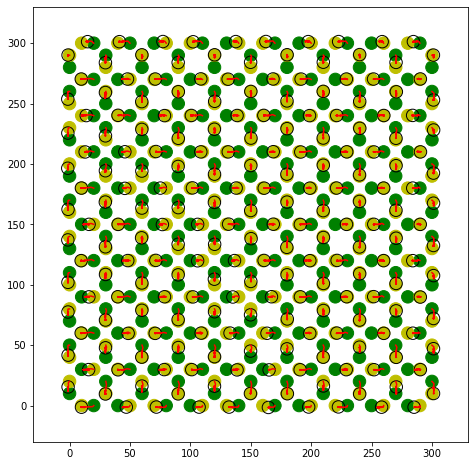

In [5]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)
for i, trj_i in col.trj.groupby("id"):
    if all(trj_i.type==1):
        plt.plot(trj_i.x,trj_i.y, color = "r")

## Create a 'vertex' object from a 'colloidal_ice' object

In [6]:
v = ice.vertices()
v.colloids_to_vertices(col)

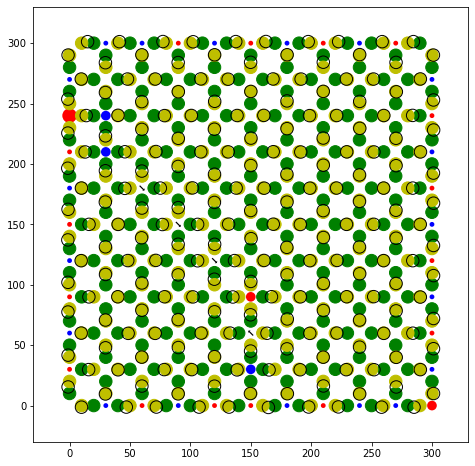

In [7]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

## Create a vertex structure from the results of lammps.

We can get the vertex structure from a trajectory. To do this, the trajectory must be in the 'ice' format obtained by 'get_ice_trj':

In [8]:
trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
trj.head()

type      x    y    z    dx   dy   dz    t   cx   cy   cz
frame id                                                           
0     1      2   15.0  0.0  0.0  10.0  0.0  0.0  0.0  5.0  0.0  0.0
      2      2   45.0  0.0  0.0  10.0  0.0  0.0  0.0  5.0  0.0  0.0
      3      2   75.0  0.0  0.0  10.0  0.0  0.0  0.0  5.0  0.0  0.0
      4      2  105.0  0.0  0.0  10.0  0.0  0.0  0.0  5.0  0.0  0.0
      5      2  135.0  0.0  0.0  10.0  0.0  0.0  0.0  5.0  0.0  0.0

Notice that in this format, the columns contain the directions and colloid positions of the traps. 

The 'vertex' class can process the results of a single frame, by giving it as an input a trajectory with a single index.

In [9]:
v = ice.vertices()
frame = 0
v = v.trj_to_vertices(trj.loc[frame])

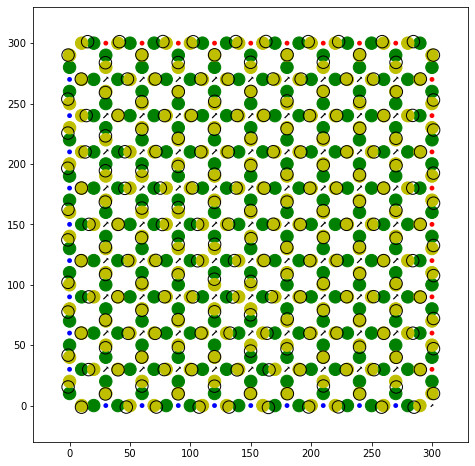

In [10]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

### Multiple frames

If the 'trj' is a MultiIndex, the 'trj_to_vertices' method will iterate over all the indices which are not 'id', and calculate the vertex structure of all frames. However, it will only calculate the topology of the first frame. 

In [11]:
%%time
v = ice.vertices()
frames = trj.index.get_level_values("frame").unique()

v.trj_to_vertices(trj.loc[frames[:]])



CPU times: user 44.8 s, sys: 1.33 s, total: 46.1 s
Wall time: 59.4 s


In [12]:
v.vertices.head()

x      y  coordination  charge   dx   dy
frame vertex                                              
0     0         0.0  210.0             3      -1  1.0  2.0
      1       300.0   30.0             3       1  1.0  2.0
      2        30.0    0.0             3      -1  2.0  1.0
      3       180.0  300.0             3       1  2.0  1.0
      4       210.0  300.0             3       1  2.0  1.0

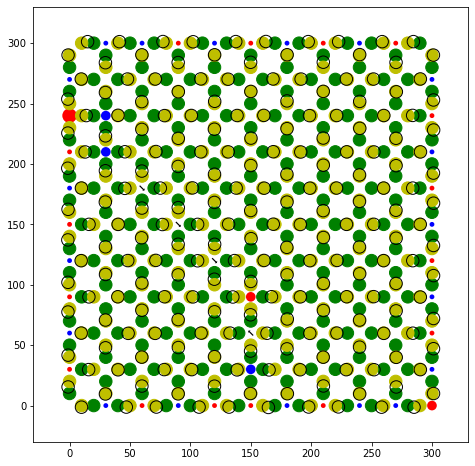

In [13]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

## Classifying and Counting vertices.

From the previous vertex object, where the trayectory of the vertices have been calculated (the time evolution of the vertices) we can then classify and count the vertices using the following procedures:

First we define a function that classifes the vertices. This means taking properties that have been calculated like charge, coordination or dipole, and asigning a "type". It's advisable to make the type an integer. 

In [14]:
def classify_vertices(vrt):
    vrt["type"] = np.NaN
    
    vrt.loc[vrt.eval("coordination==4 & charge == -4"),"type"] = 1
    vrt.loc[vrt.eval("coordination==4 & charge == -2"),"type"] = 2
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)==0"),"type"] = 3
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)>0"),"type"] = 4
    vrt.loc[vrt.eval("coordination==4 & charge == 2"),"type"] = 5
    vrt.loc[vrt.eval("coordination==4 & charge == 4"),"type"] = 6
    return vrt

v.vertices = classify_vertices(v.vertices)

Now, we can use the builtin function `count_vertices`, which takes a column, and get's the total number o vertices for which the given column is of a given unique value. 

In [15]:
count = ice.count_vertices(v.vertices)

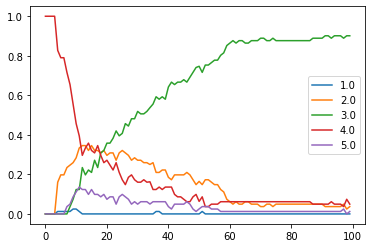

In [16]:
for t,v_t in count.groupby("type"):
    plt.plot(v_t.index.get_level_values("frame"), v_t.fraction, label = t)
plt.legend()